# <b>[핸즈온 머신러닝]</b> <br>
# Chapter 03 분류

## 3.1 MNIST

In [1]:
#MNIST 데이터셋 다운로드
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

사이킷런에서 읽어 들인 데이터셋들의 구조
- 데이터셋을 설명하는 DESCR 키
- 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
- 레이블 배열을 담은 target 키

In [2]:
X, y = mnist['data'], mnist['target']

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

이미지가 70000개 있고 각 이미지에는 784개의 특성이 있음

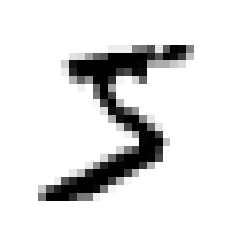

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28) #샘플의 특성 벡터를 추출해서 28x28 배열로 크기 바꿈

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [6]:
#실제 레이블 확인
y[0]

'5'

In [7]:
#문자열인 레이블 정수로 변환
import numpy as np

y = y.astype(np.uint8)

In [8]:
#train set, test set 나누기
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

- 훈련 세트는 이미 섞여 있어서 모든 교차 검증 폴드를 비슷하게 만듦
- 어떤 학습 알고리즘은 훈련 샘플의 순서에 민감해서 많은 비슷한 샘플이 연이어 나타나면 성능이 나빠짐
- 데이터셋을 섞으면 이런 문제를 방지할 수 있음 (시계열 데이터를 다룰 때는 섞는 것이 좋지 않음)

## 3.2 이진 분류기 훈련 <br>
- 5-감지기: '5'와 '5 아님' 두 개의 클래스를 구분할 수 있는 이진 분류기(binary classifier)의 한 예

In [9]:
y_train_5 = (y_train == 5) #5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

- `확률적 경사 하강법 (Stochastic Gradient Descent, SGD)` 분류기
    - 사이킷런의 'SGDClassifier 클래스' 사용
    - 매우 큰 데이터셋을 효율적으로 처리하는 장점을 지니고 있음
    - SGD가 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문에 온라인 학습에 잘 들어맞음

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

분류기는 이 이미지가 5를 나타낸다고 추측했음 (True)

## 3.3 성능 측정 <br>
### 3.3.1 교차 검증을 사용한 정확도 측정

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.95035
0.96035
0.9604


- StratifiedKFold는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행함
- 매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만듦
- 그 다음 올바른 예측의 수를 세어 정확한 예측의 비율을 출력함

In [12]:
from sklearn.model_selection import cross_val_score

#cross_val_score() 함수로 폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassifier 모델 평가
#k-겹 교차 검증은 훈련 세트를 k개의 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용함
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

- 이미지의 10% 정도만 숫자 5이기 때문에 무조건 '5 아님'으로 예측하면 정확히 맞출 확률이 90%임
- 이 예제는 정확도의 분류기를 성능 측정 지표로 선호하지 않는 이유를 보여줌
- 특히, 불균형한 데이터셋을 다룰 때 (즉, 어떤 클래스가 다른 것보다 월등히 많은 경우) 더욱 그러함

### 3.3.2 오차 행렬 <br>
- 분류기의 성능을 평가하는 더 좋은 방법은 `오차 행렬 (confusion matrix)`을 조사하는 것임
- 기본적인 아이디어는 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것임
- 예를 들어, 분류기가 숫자 5의 이미지를 3으로 잘못 분류한 횟수를 알고 싶다면 오차 행렬의 5행 3열을 보면 됨

In [15]:
from sklearn.model_selection import cross_val_predict

#오차 행렬을 만들려면 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 함
#테스트 세트로 예측을 만들 수 있지만 여기서 사용하면 안됨
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

- `cross_val_predict()` 함수는 cross_val_score() 함수처럼 k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환함
- 즉, 훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻게 됨

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

- 오차 행렬의 행은 '실제 클래스', 열은 '예측한 클래스'
- 이 행렬의 첫 번째 행은 '5 아님' 이미지 (음성 클래스, negative class)에 대한 것으로, 53892개를 '5 아님'으로 정확하게 분류했고 (진짜 음성, true negative) 나머지 687개는 '5'라고 잘못 분류함 (거짓 양성, false positive)
- 두 번째 행은 '5' 이미지 (양성 클래스, positive class)에 대한 것으로, 1891개를 '5 아님'으로 잘못 분류했고 (거짓 음성, false negative) 나머지 3530개를 정확히 '5'라고 분류함 (진짜 양성, true positive)
- 완벽한 분류기라면 진짜 양성과 진짜 음성만 가지고 있을 것이므로 오차 행렬의 주대각선만 0이 아닌 값이 됨

In [17]:
y_train_perfect_predictions = y_train_5 #완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

- 오차 행렬이 많은 정보를 제공해주지만 가끔 더 요약된 지표가 필요할 때도 있음
 <br><br>
- `정밀도 (precision)`: 양성 예측의 정확도
$$ 정밀도 = \frac {TP}{TP+FP} $$
- TP: 진짜 양성의 수, FP: 거짓 양성의 수
- 확실한 양성 샘플 하나마나 예측하면 간단히 완벽한 정밀도를 얻을 수 있지만, 이는 분류기가 다른 모든 양성 샘플을 무시하기 때문에 그리 유용하지 않음
- 정밀도는 재현율이라는 또 다른 지표와 같이 사용하는 것이 일반적임
<br><br>
- `재현율 (recall)`: 분류기가 정확하게 감지한 양성 샘플의 비율로 민감도 (sensitivity) 또는 진짜 양성 비율 (true positive rate, TPR)이라고도 함
$$ 재현율 = \frac {TP}{TP+FN} $$
- FN: 거짓 음성의 수
<br><br>
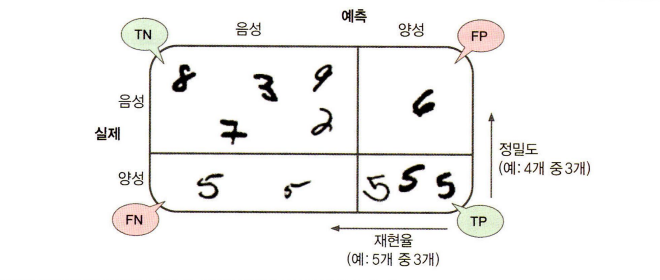 <br>
이 오차 행렬 그림은 진짜 음성 샘플(왼쪽 위), 거짓 양성(오른쪽 위), 거짓 음성(왼쪽 아래), 진짜 양성(오른쪽 아래)를 보여줌

### 3.3.3 정밀도와 재현율

In [18]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 3530 / (3530 + 687)

0.8370879772350012

In [19]:
recall_score(y_train_5, y_train_pred) # == 3530 / (3530 + 1891)

0.6511713705958311

- 정밀도와 재현율을 F1 점수라고 하는 하나의 숫자로 만들면 편리할 때가 많음 (특히 두 분류기를 비교할 때)
- `F1 점수 (F1 score)`: 정밀도와 재현율의 조화 평균
$$ F_1 = \frac {2}{ \frac{1}{정밀도} + \frac{1}{재현율} } = 2 \times \frac {정밀도 \times 재현율}{정밀도 + 재현율} = \frac {TP}{TP + \frac{FN+FP}{2}} $$
- 정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높지만 이게 항상 바람직한 것은 아님
- 상황에 따라 정밀도가 중요할 수도 있고 재현율이 중요할 수도 있음
- `정밀도/재현율 트레이드오프`: 정밀도를 올리면 재현율이 줄고 그 반대도 마찬가지인 상황

In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 3.3.4 정밀도/재현율 트레이드오프 <br>
- SGDClassifier 분류기는 결정 함수(decision function)를 사용하여 각 샘플의 점수를 계산함
- 이 점수가 임계값보다 크면 샘플을 양성 클래스에 할당하고 그렇지 않으면 음성 클래스에 할당함 <br>
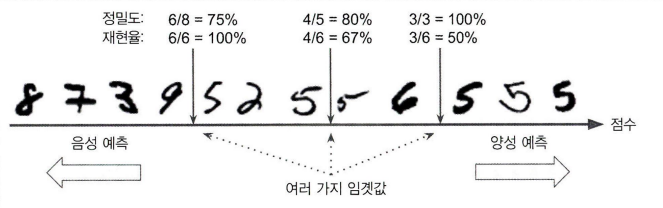 <br>
- 임계값을 높이면 (임계값을 오른쪽 화살표로 옮기면) 정밀도가 높아지고 재현율이 줄어듦
- 반대로 임계값을 내리면 재현율이 높아지고 정밀도가 줄어듦

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [22]:
threshold = 0 #임계값
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [23]:
threshold = 8000 #임계값 높임
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred #재현율이 줄어듦

array([False])

In [24]:
#적절한 임계값을 정하려면 cross_val_predict() 함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해야 함
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

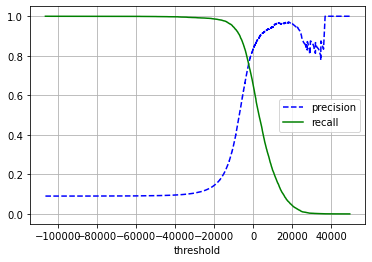

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='recall')
    plt.legend()
    plt.xlabel('threshold')
    plt.grid()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

#임계값을 올리더라도 정밀도가 가끔 낮아질 때가 있기 때문에 정밀도 곡선이 재현율 곡선보다 더 울퉁불퉁함

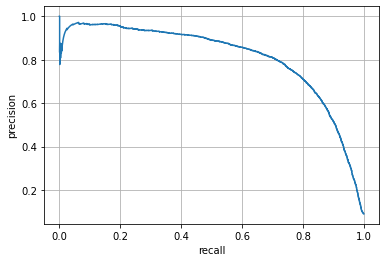

In [27]:
plt.plot(recalls[:-1], precisions[:-1])
plt.xlabel('recall')
plt.ylabel('precision')
plt.grid()
plt.show()

- 재현율 80% 근처에서 정밀도가 급격하게 줄어들기 시작하므로 이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋음 (재현율이 60% 정도인 지점)
- 정밀도 90%를 달성하는 것이 목표라고 가정하면 임계값이 약 8000 정도임
- 조금 더 정확하게 최소한 90% 정밀도가 되는 가장 낮은 임계값을 찾을 수 있음

In [28]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [29]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [30]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### 3.3.5 ROC 곡선 <br>
- `수신기 조작 특성 (receiver operating characteristic, ROC) 곡선`
    - 정밀도/재현율 곡선과 매우 비슷하지만 정밀도에 대한 재현율 곡선이 아님
    - 거짓 양성 비율 (false positive rate, FPR)에 대한 진짜 양성 비율 (true positive rate, TPR, 재현율)의 곡선임
    - FPR: 양성으로 잘못 분류된 음성 샘플의 비율로 이는 1에서 음성으로 정확하게 분류한 음성 샘플의 비율인 진짜 음성 비율 (true negative rate, TNR)을 뺀 값임
    - TNR: 특이도 (specificity)라고도 함
    - $\to$ ROC 곡선은 민감도(재현율)에 대한 1-특이도 그래프

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

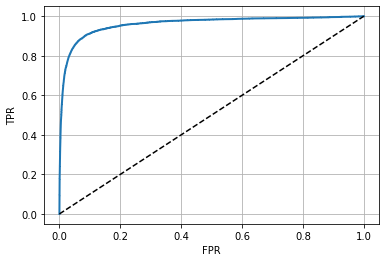

In [32]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--') #대각 점선
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid()
    
plot_roc_curve(fpr, tpr)
plt.show()

- 여기에서도 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어난다는 트레이드오프가 있음
- 점선은 완전한 랜덤 분류기의 ROC 곡선을 뜻함
- 좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있어야 함 (왼쪽 위 모서리)
<br><br>
- 곡선 아래의 면적 (area under the curve, AUC)을 측정하면 분류기들을 비교할 수 있음
- 완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5임
<br><br>
- 일반적인 법칙은 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 PR(정밀도/재현율) 곡선을 사용하고 그렇지 않으면 ROC 곡선을 사용함

In [33]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [34]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')
#predict_proba() 메소드는 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환함

In [35]:
y_scores_forest = y_probas_forest[:,1] #양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

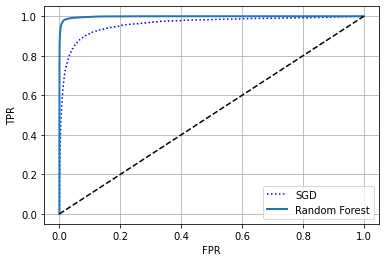

In [36]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

- RandomForestClassifier의 ROC 곡선이 왼쪽 위 모서리에 더 가까워 SGDClassifier보다 훨씬 좋아 보임
- 당연하게 ROC AUC 점수도 훨씬 높음

In [37]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## 3.4 다중 분류 <br>
- 이진 분류가 두 개의 클래스를 구별하는 반면, `다중 분류기 (multiclass classifier)` 또는 `다항 분류기 (multinomial classifier)`는 둘 이상의 클래스를 구별할 수 있음
- SGD 분류기, 랜덤 포레스트 분류기, 나이브 베이즈(naive Bayes) 분류기 같은 일부 알고리즘은 여러 개의 클래스를 직접 처리할 수 있는 반면, 로지스틱 회귀나 서포트 벡터 머신 분류기 같은 다른 알고리즘은 이진 분류만 가능함
<br><br>
- 하지만 이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법도 많음
- `OvR (one-versus-the-rest) 전략` 혹은 `OvA (one-versus-all) 전략`
    - 이미지를 분류할 떄 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택하면 됨
- `OvO (one-versus-one) 전략`
    - 또 다른 전략은 0과 1 구별, 0과 2 구별, 1과 2 구별 등과 같이 각 숫자의 조합마다 이진 분류기를 훈련시키는 것임
    - 클래스가 N개라면, 분류기는 Nx(N-1)/2개가 필요함
<br><br>
- 서포트 벡터 머신 같은 일부 알고리즘은 훈련 세트의 크기에 민감해서 큰 훈련 세트에서 몇 개의 분류기를 훈련시키는 것보다 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빠르므로 OvO를 선호하지만 대부분의 이진 분류 알고리즘에서는 OvR을 선호함
- 다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 알고리즘에 따라 자동으로 OvR 또는 OvO를 실행함

In [38]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) #y_train_5가 아니고 y_train 사용
svm_clf.predict([some_digit])

array([5], dtype=uint8)

- 위 코드는 5를 구별한 타깃 클래스(y_train_5) 대신 0에서 9까지의 원래 타깃 클래스(y_train)를 사용해 SVC를 훈련시킴
- 그런 다음 예측 하나를 만들고 내부에서는 사이킷런이 OvO 전략을 사용해 10개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택함

In [39]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [40]:
np.argmax(some_digit_scores)

5

In [41]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [42]:
svm_clf.classes_[5]

5

- 분류기가 훈련될 때 classes_ 속성에 타깃 클래스의 리스트를 값으로 정렬하여 저장함
- 위 예제에서는 classes_ 배열에 있는 각 클래스의 인덱스가 클래스 값 자체와 같지만 일반적으로 이런 경우는 드묾

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

In [ ]:
len(ovr_clf.estimators_)

In [ ]:
#SGDClassifer 훈련
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

In [ ]:
#decision_function() 메소드: 클래스마다 하나의 값 반환
sgd_clf.decision_function([some_digit])

In [ ]:
#SGDClassifier의 정확도 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

## 3.5 에러 분석

In [ ]:
#오차 행렬 살펴보기
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
#matshow() 함수를 사용해 오차 행렬 이미지로 표현
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

- 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 매우 좋아 보임
- 숫자 5는 다른 숫자보다 조금 더 어두워 보이는데, 이는 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻임

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
#오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교
norm_conf_mx = conf_mx / row_sums

In [ ]:
#다른 항목은 그대로 유지하고 주대각선만 0으로 채워서 그래프 그림
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

- 행: 실제 클래스, 열: 예측한 클래스
<br><br>
- 클래스 8의 열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류되었음을 암시함
- 하지만 클래스 8의 행은 그리 나쁘지 않으므로 실제 8이 적절히 8로 분류되었다는 것임
<br><br>
- 오차 행렬을 분석하면 성능 향상 방안에 대한 통찰을 얻을 수 있음
- 여기서는 8처럼 보이는 숫자의 훈련 데이터를 더 많이 모아서 실제 8과 구분하도록 분류기를 학습시킬 수 있음
- 예를 들어 동심원의 수를 세는 알고리즘을 사용하거나 동심원 같은 어떤 패턴이 드러나도록 Scikit-Image, Pillow, OpenCV 등을 사용해서 이미지를 전처리해볼 수 있음

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

- 왼쪽의 5x5 블록 두 개는 3으로 분류된 이미지이고 오른쪽 5x5 블록 두 개는 5로 분류된 이미지임
- 선형 모델인 SGDClassifier을 사용했기 때문에 분류기가 실수한 이유를 이해하기 어려움
- 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산함
- 따라서, 3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 쉽게 혼동하게 됨
- 3과 5의 에러를 줄이는 한 가지 방법은 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하는 것임

## 3.6 다중 레이블 분류 <br>
- `다중 레이블 분류 (multilabel classification) 시스템`: 여러 개의 이진 꼬리표를 출력하는 분류 시스템
- 예를 들어, 같은 사진에 여러 사람이 등장할 경우에 인식된 사람마다 하나씩 꼬리표를 붙이는 시스템
- 분류기가 앨리스, 밥, 찰리 세 얼굴을 인식하도록 훈련되어있다고 가정했을 때, 분류기가 앨리스와 찰리가 있는 사진을 본다면 [1,0,1]을 출력함

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

#각 숫자 이미지에 두 개의 타겟 레이블이 담긴 y_multilabel 배열을 만듦
y_train_large = (y_train >= 7) #숫자가 큰 값 (7,8,9)인지 나타냄
y_train_odd = (y_train % 2 == 1) #홀수인지 나타냄
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
knn_clf.predict([some_digit])

숫자 5는 크지 않고 (False) 홀수 (True)이므로 올바르게 분류됨

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro') #모든 레이블에 대한 F1 점수의 평균 계산

## 3.7 다중 출력 분류 <br>
- `다중 출력 다중 클래스 분류 (multioutput-multiclass classification)` 또는 `다중 출력 분류 (multioutput classification)`
    - 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것
    - 즉, 값을 두 개 이상 가질 수 있음
<br><br>
- 예시) 이미지에서 잡음을 제거하는 시스템
    - 잡음이 많은 숫자 이미지를 입력으로 받고 깨끗한 숫자 이미지를 MNIST 이미지처럼 픽셀의 강도를 담은 배열로 출력
    - 분류기의 출력이 다중 레이블 (픽셀당 한 레이블)이고 각 레이블 값을 여러 개 가짐 (0부터 255까지 픽셀 강도)
    - 그러므로 이 예는 다중 출력 분류 시스템임

In [ ]:
#randint() 함수를 사용하여 픽셀 강도에 잡음 추가
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

왼쪽: 잡음 섞인 입력 이미지, 오른쪽: 깨끗한 타깃 이미지 <br>
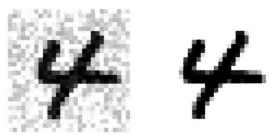

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

분류기를 훈련하여 만든 깨끗한 이미지<br>
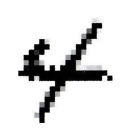